In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from torchinfo import summary
from skimage import io
import os
import pandas as pd
from skimage import transform as tr
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tqdm
from datetime import datetime
import pytz
from torchmetrics.classification import BinaryJaccardIndex

C:\Users\hilst\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from scipy import ndimage as ndi
import napari
from skimage.feature import peak_local_max
from skimage import measure
from skimage import segmentation

In [155]:
#Defining paths for loading data
root = path = "C:/Users/hilst/Documents/Biomedical Engineering/Deep Learning/embryodata/"
train_data_path = root + "Images/Images/train/Images/"
test_data_path = root + "Images/Images/test/Images/"
ground_truth_data_path = root + "GroundTruth/GroundTruth/train/GroundTruth_NSN/"
ground_truth_data_path_NDN = root + "GroundTruth/GroundTruth/train/GroundTruth_NDN/"
ground_truth_test = root + "GroundTruth/GroundTruth/test/GroundTruth_QCANet/"

train_data_paths = np.array([train_data_path+i for i in os.listdir(train_data_path)])
test_data_paths = np.array([test_data_path+i for i in os.listdir(test_data_path)])

In [101]:
#funtion for applying watershed to output of networks
def Watershed_function(output_NSN, output_NDN, output_unet):

    #Relative length of the voxel-sides
    #spacing = np.array([0.8,1.75,1.75])
    spacing = np.array([1,1,1])

    #Article does not mention if watershed is also applied to Unet results, or how the instance segmentation is being done
    unet_watershed = False
    NSN_watershed = False

    if not unet_watershed:
        #Non-watershed filtering for Unet
        segmented_unet = measure.label(output_unet==1)
    else:    
        transformed_unet = ndi.distance_transform_edt(output_unet==1, sampling=spacing)
        maxima_unet = peak_local_max(transformed_unet, min_distance = 8)
        markers_unet = np.zeros(output_unet.shape, dtype=np.uint32)
        marker_indices_unet = tuple(np.round(maxima_unet).astype(int).T)
        markers_unet[marker_indices_unet] = np.arange(len(maxima_unet)) + 1
        segmented_unet = segmentation.watershed(output_unet,markers_unet,mask=output_unet==1)

    if not NSN_watershed:
        #Non-watershed filtering for Unet
        segmented_NSN = measure.label(output_NSN==1)
    else:    
        transformed_NSN = ndi.distance_transform_edt(output_NSN==1, sampling=spacing)
        maxima_NSN = peak_local_max(transformed_NSN, min_distance = 8)
        markers_NSN = np.zeros(output_NSN.shape, dtype=np.uint32)
        marker_indices_NSN = tuple(np.round(maxima_NSN).astype(int).T)
        markers_NSN[marker_indices_NSN] = np.arange(len(maxima_NSN)) + 1
        segmented_NSN = segmentation.watershed(output_NSN,markers_NSN,mask=output_NSN==1)

    #Watershed for NDN & NSN combination
    #find one point for each nucleus, by calculating distance and finding local maxima
    transformed = ndi.distance_transform_edt(output_NDN==1, sampling=spacing)
    maxima = peak_local_max(transformed, min_distance = 8)

    #make an image with labeled markers on the coordinates of the maxima
    markers = np.zeros(output_NSN.shape, dtype=np.uint32)
    marker_indices = tuple(np.round(maxima).astype(int).T)
    markers[marker_indices] = np.arange(len(maxima)) + 1

    #perform the watershed algorithm from the markers and form a labeled mask
    segmented_QCANet = segmentation.watershed(output_NSN,markers,mask=output_NSN==1)
    
    return segmented_NSN, segmented_QCANet, segmented_unet


In [100]:
def viewing3D_funtion(output_NSN, output_NDN, output_unet, segmented_NSN, segmented_QCANet,segmented_unet):
    #viewing the results of the labeling in 3D
    #Relative length of the voxel-sides
    #spacing = np.array([0.8,1.75,1.75])
    spacing = np.array([1,1,1])

    viewer = napari.view_image(
        output_NSN,
        contrast_limits=[0, 1],
        scale=spacing,
        ndisplay=3,
    )

    viewer.add_image(
        output_NDN,
        scale=spacing,
        blending='additive',
        colormap='magenta',
    )

    viewer.add_image(
        output_unet,
        scale=spacing,
        blending='additive',
        colormap='green',
    )

    viewer.add_labels(
        segmented_QCANet,
        scale=spacing
    )

    viewer.add_labels(
        segmented_NSN,
        scale=spacing
    )

    viewer.add_labels(
        segmented_unet,
        scale=spacing
    )

In [6]:
#Custom Torch dataset class to create a dataset and pass it to Torch dataloaders
class EmbryoImageDataset(Dataset):
    def __init__(self, 
                 image_paths, 
                 ground_truth_dir, 
                 transform=None, 
                 flip_augmentation = [False, None],
                test_data = False):
        self.ground_truth_dir = ground_truth_dir
        self.image_paths = image_paths
        self.transform = transform
        self.flip_augmentation = flip_augmentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = io.imread(self.image_paths[index])
        filename = self.image_paths[index].split('/')[-1]
        ground_truth = io.imread(self.ground_truth_dir + filename)
        
        if self.transform is not None:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)
            
        if self.flip_augmentation[0]:
            #print("FLIPPING", self.flip_augmentation[0], self.flip_augmentation[1] )
            image = np.flip(image, axis = self.flip_augmentation[1])
            ground_truth = np.flip(ground_truth, axis = self.flip_augmentation[1])
            
        if test_data: 
            #Ground truth of test data was instance segmentation ground truth, therefore all values bigger than 0 should be set to 1
            ground_truth = ((ground_truth>0)*1).astype(ground_truth.dtype) 
    
        return torch.from_numpy(image.copy().astype('float32')), torch.from_numpy(ground_truth.copy().astype('float32'))
    

class NormalizeImage(object):
    
    def __init__(self):
        pass
    
    def __call__(self, image):
        
        img = (image-np.min(image))/(np.max(image)-np.min(image))
        
        return img
    
#Class that can perform a transform that interpolates the images along z, according to the resolution. 
# This class also makes sure that the object is of the desired size. In this case 128x128x128
class Resize_and_pad(object):
    
    def __init__(self, resolution = [0.8,0.8,1.75], desired_size = 128):
        
        self.resolution = resolution
        self.desired_size = desired_size
        
    def __call__(self, image):
        
        
        shape = np.shape(image)
        resize_factor = np.array(self.resolution)/0.8

        resized_image = tr.resize(image, 
                                  (shape[0]*resize_factor[2], 
                                   shape[1]*resize_factor[1], 
                                   shape[2]*resize_factor[0]),
                                     order=1)
        
        delta_shape = [128-value for value in resized_image.shape]
        max_pad_width = np.max(delta_shape)

        padded_image = np.pad(resized_image,[[0,max_pad_width],[0,max_pad_width],[0,max_pad_width]], mode = 'reflect')
        final_image = padded_image[:self.desired_size,:self.desired_size,:self.desired_size]
        
        return final_image

In [156]:
#Here the train and test dataset are created

#For the test set there was a different resolution so different transformation is needed
composed_test = composed = transforms.Compose([NormalizeImage(), Resize_and_pad(resolution= [0.8,0.8,2.0])])

#Creating the test dataset for when the model is fully trained
test_data = EmbryoImageDataset(image_paths = test_data_paths,
                              ground_truth_dir= ground_truth_test,
                              test_data= True, transform = composed_test)

train_data = EmbryoImageDataset(image_paths = train_data_paths,
                              ground_truth_dir= ground_truth_data_path,
                              test_data= True, transform = composed_test)

print(len(test_data))

44


In [8]:
#Our own very straightforward, albeit not super nice, implementation of the U-net 3D architecture by the paper: '3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation'
class UNet3D(nn.Module):
    
    def __init__(self, in_channels = 1, out_channels = 1):
        super(UNet3D, self).__init__()
        
        #Activation functions and maxpooling
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #Encoder Block 1
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn2 = nn.BatchNorm3d(64)
        
        #Encoder Block 2
        self.conv3 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn3 = nn.BatchNorm3d(64)
        self.conv4 = nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn4 = nn.BatchNorm3d(128)
        
        #Encoder Block 3
        self.conv5 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn5 = nn.BatchNorm3d(128)
        self.conv6 = nn.Conv3d(in_channels = 128, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn6 = nn.BatchNorm3d(256)
        
        #Bottleneck block
        self.conv7 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn7 = nn.BatchNorm3d(256)
        self.conv8 = nn.Conv3d(in_channels = 256, out_channels = 512, kernel_size = (3,3,3), padding = 1)
        self.bn8 = nn.BatchNorm3d(512)
        
        #Decoder Block 1
        self.upconv1 = nn.ConvTranspose3d(in_channels = 512, out_channels = 512, kernel_size = (2,2,2), stride = 2)
        self.conv9 = nn.Conv3d(in_channels = 512+256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn9 = nn.BatchNorm3d(256)
        self.conv10 = nn.Conv3d(in_channels = 256, out_channels = 256, kernel_size = (3,3,3), padding = 1)
        self.bn10 = nn.BatchNorm3d(256)
        
        #Decoder Block 2
        self.upconv2 = nn.ConvTranspose3d(in_channels = 256, out_channels = 256, kernel_size = (2,2,2), stride = 2)
        self.conv11 = nn.Conv3d(in_channels = 256+128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn11 = nn.BatchNorm3d(128)
        self.conv12 = nn.Conv3d(in_channels = 128, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn12 = nn.BatchNorm3d(128)
        
        #Decoder Block 3 
        self.upconv3 = nn.ConvTranspose3d(in_channels = 128, out_channels = 128, kernel_size = (2,2,2), stride = 2)
        self.conv13 = nn.Conv3d(in_channels = 128+64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn13 = nn.BatchNorm3d(64)
        self.conv14 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn14 = nn.BatchNorm3d(64)
        
        #Final convolution
        self.conv15 = nn.Conv3d(in_channels = 64, out_channels = out_channels, kernel_size = (1,1,1))
        
    def forward(self, input):

        #Encoder Block 1
        out = self.relu(self.bn1(self.conv1(input)))
        out = self.relu(self.bn2(self.conv2(out)))
        skip_connection1 = out
        out = self.maxpool(out)

        #Encoder Block 2
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        skip_connection2 = out
        out = self.maxpool(out)

        #Encoder Block 3
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        skip_connection3 = out
        out = self.maxpool(out)

        #Bottleneck layer
        out = self.relu(self.bn7(self.conv7(out)))
        out = self.relu(self.bn8(self.conv8(out)))

        #Decoder Block 1
        out = self.upconv1(out)
        out = torch.cat(tensors = (out, skip_connection3), dim = 1)
        out = self.relu(self.bn9(self.conv9(out)))
        out = self.relu(self.bn10(self.conv10(out)))

        #Decoder Block 2
        out = self.upconv2(out)
        out = torch.cat(tensors = (out, skip_connection2), dim = 1)
        out = self.relu(self.bn11(self.conv11(out)))
        out = self.relu(self.bn12(self.conv12(out)))

        #Decoder Block 3
        out = self.upconv3(out)
        out = torch.cat(tensors = (out, skip_connection1), dim = 1)
        out = self.relu(self.bn13(self.conv13(out)))
        out = self.relu(self.bn14(self.conv14(out)))

        #Final convolution + sigmoid activation
        out = self.conv15(out)
        out = self.sig(out)

        return out
    
#Prediction accuracy measure
def IoU(prediction, ground_truth):
    
    #We first apply a threshold to the prediction, to ensure a binary mask is made that can be 
    #compared to the ground truth. Ground truth should already be a binary mask
    
    threshold = 0.5
    
    prediction = (prediction.squeeze()>threshold)*1
    ground_truth = ground_truth.squeeze()
    

    pred_diff = prediction.flatten()-ground_truth.flatten()
    
    TP = torch.sum((pred_diff == 0)*ground_truth.flatten()) #Amount of true positives
    FP_or_FN = torch.sum(pred_diff!= 0) #Amount of false positives and false negatives
    
    value = TP/(TP+FP_or_FN)
    
    return value

In [9]:
class NDN_Net(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 1):
        super(NDN_Net, self).__init__()
        
        #Activation functions and maxpooling
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid() 
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #Encoder Block 1
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 12, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn1 = nn.BatchNorm3d(12)
        self.conv2 = nn.Conv3d(in_channels = 12, out_channels = 24, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn2 = nn.BatchNorm3d(24)
        
        #Encoder Block 2
        self.conv3 = nn.Conv3d(in_channels = 24, out_channels = 24, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn3 = nn.BatchNorm3d(24)
        self.conv4 = nn.Conv3d(in_channels = 24, out_channels = 48, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn4 = nn.BatchNorm3d(48)
        
        #Encoder Block 3
        self.conv5 = nn.Conv3d(in_channels = 48, out_channels = 48, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn5 = nn.BatchNorm3d(48)
        self.conv6 = nn.Conv3d(in_channels = 48, out_channels = 96, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn6 = nn.BatchNorm3d(96)
        
        #Encoder Block 4
        self.conv7 = nn.Conv3d(in_channels = 96, out_channels = 96, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn7 = nn.BatchNorm3d(96)
        self.conv8 = nn.Conv3d(in_channels = 96, out_channels = 192, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn8 = nn.BatchNorm3d(192)
        
        #Bottleneck block
        self.conv9 = nn.Conv3d(in_channels = 192, out_channels = 192, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn9 = nn.BatchNorm3d(192)
        self.conv10 = nn.Conv3d(in_channels = 192, out_channels = 384, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn10 = nn.BatchNorm3d(384)
        
        #Decoder Block 1
        self.upconv1 = nn.ConvTranspose3d(in_channels = 384, out_channels = 384, kernel_size = (2,2,2), padding = 0, stride = 2)
        self.conv11 = nn.Conv3d(in_channels = 384+192, out_channels = 192, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn11 = nn.BatchNorm3d(192)
        self.conv12 = nn.Conv3d(in_channels = 192, out_channels = 192, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn12 = nn.BatchNorm3d(192)
        
        #Decoder Block 2
        self.upconv2 = nn.ConvTranspose3d(in_channels = 192, out_channels = 192, kernel_size = (2,2,2), padding = 0, stride = 2)
        self.conv13 = nn.Conv3d(in_channels = 192+96, out_channels = 96, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn13 = nn.BatchNorm3d(96)
        self.conv14 = nn.Conv3d(in_channels = 96, out_channels = 96, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn14 = nn.BatchNorm3d(96)
        
        #Decoder Block 3 
        self.upconv3 = nn.ConvTranspose3d(in_channels = 96, out_channels = 96, kernel_size = (2,2,2), stride = 2)
        self.conv15 = nn.Conv3d(in_channels = 96+48, out_channels = 48, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn15 = nn.BatchNorm3d(48)
        self.conv16 = nn.Conv3d(in_channels = 48, out_channels = 48, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn16 = nn.BatchNorm3d(48)
        
        #Decoder Block 4
        self.upconv4 = nn.ConvTranspose3d(in_channels = 48, out_channels = 48, kernel_size = (2,2,2), stride = 2)
        self.conv17 = nn.Conv3d(in_channels = 48+24, out_channels = 24, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn17 = nn.BatchNorm3d(24)
        self.conv18 = nn.Conv3d(in_channels = 24, out_channels = 24, kernel_size = (5,5,5), padding = 2, stride = 1)
        self.bn18 = nn.BatchNorm3d(24)
        
        #Final convolution
        self.conv19 = nn.Conv3d(in_channels = 24, out_channels = out_channels, kernel_size = (1,1,1), padding = 0, stride = 1)
        
    def forward(self, input):

        #Encoder Block 1
        out = self.relu(self.bn1(self.conv1(input)))
        out = self.relu(self.bn2(self.conv2(out)))
        skip_connection1 = out
        out = self.maxpool(out)

        #Encoder Block 2
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        skip_connection2 = out
        out = self.maxpool(out)

        #Encoder Block 3
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        skip_connection3 = out
        out = self.maxpool(out)
        
        #Encoder Block 4
        out = self.relu(self.bn7(self.conv7(out)))
        out = self.relu(self.bn8(self.conv8(out)))
        skip_connection4 = out
        out = self.maxpool(out)

        #Bottleneck layer
        out = self.relu(self.bn9(self.conv9(out)))
        out = self.relu(self.bn10(self.conv10(out)))

        #Decoder Block 1
        out = self.upconv1(out)
        out = torch.cat(tensors = (out, skip_connection4), dim = 1)
        out = self.relu(self.bn11(self.conv11(out)))
        out = self.relu(self.bn12(self.conv12(out)))

        #Decoder Block 2
        out = self.upconv2(out)
        out = torch.cat(tensors = (out, skip_connection3), dim = 1)
        out = self.relu(self.bn13(self.conv13(out)))
        out = self.relu(self.bn14(self.conv14(out)))

        #Decoder Block 3
        out = self.upconv3(out)
        out = torch.cat(tensors = (out, skip_connection2), dim = 1)
        out = self.relu(self.bn15(self.conv15(out)))
        out = self.relu(self.bn16(self.conv16(out)))

        #Decoder Block 4
        out = self.upconv4(out)
        out = torch.cat(tensors = (out, skip_connection1), dim = 1)
        out = self.relu(self.bn17(self.conv17(out)))
        out = self.relu(self.bn18(self.conv18(out)))
        
        #Final convolution + sigmoid activation
        out = self.conv19(out)
        out = self.sig(out) 

        return out

In [10]:
class NSN(nn.Module):
    
    def __init__(self, in_channels = 1, out_channels = 1): 
        super(NSN, self).__init__()
        
        #Activation functions and maxpooling
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #Encoder Block 1
        self.conv1 = nn.Conv3d(in_channels = in_channels, out_channels = 16, kernel_size = (3,3,3), padding = 1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn2 = nn.BatchNorm3d(32)
        
        #Encoder Block 2
        self.conv3 = nn.Conv3d(in_channels = 32, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn3 = nn.BatchNorm3d(32)
        self.conv4 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn4 = nn.BatchNorm3d(64)
        
        #Bottleneck block
        self.conv5 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn5 = nn.BatchNorm3d(64)
        self.conv6 = nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = (3,3,3), padding = 1)
        self.bn6 = nn.BatchNorm3d(128)
        
        #Decoder Block 1
        self.upconv1 = nn.ConvTranspose3d(in_channels = 128, out_channels = 128, kernel_size = (2,2,2), stride = 2)
        self.conv7 = nn.Conv3d(in_channels = 128+64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn7 = nn.BatchNorm3d(64)
        self.conv8 = nn.Conv3d(in_channels = 64, out_channels = 64, kernel_size = (3,3,3), padding = 1)
        self.bn8 = nn.BatchNorm3d(64)
       
        #Decoder Block 2
        self.upconv2 = nn.ConvTranspose3d(in_channels = 64, out_channels = 64, kernel_size = (2,2,2), stride = 2)
        self.conv9 = nn.Conv3d(in_channels = 64+32, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn9 = nn.BatchNorm3d(32)
        self.conv10 = nn.Conv3d(in_channels = 32, out_channels = 32, kernel_size = (3,3,3), padding = 1)
        self.bn10 = nn.BatchNorm3d(32)
        
        #Final convolution
        self.conv11 = nn.Conv3d(in_channels = 32, out_channels = out_channels, kernel_size = (1,1,1))
        
    def forward(self, input):

        #Encoder Block 1
        out = self.relu(self.bn1(self.conv1(input)))
        out = self.relu(self.bn2(self.conv2(out)))
        skip_connection1 = out
        out = self.maxpool(out)

        #Encoder Block 2
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        skip_connection2 = out
        out = self.maxpool(out)

        #Bottleneck layer
        out = self.relu(self.bn5(self.conv5(out)))
        out = self.relu(self.bn6(self.conv6(out)))
        
        #Decoder Block 1
        out = self.upconv1(out)
        out = torch.cat(tensors = (out, skip_connection2), dim = 1)
        out = self.relu(self.bn7(self.conv7(out)))
        out = self.relu(self.bn8(self.conv8(out)))

        #Decoder Block 2
        out = self.upconv2(out)
        out = torch.cat(tensors = (out, skip_connection1), dim = 1)
        out = self.relu(self.bn9(self.conv9(out)))
        out = self.relu(self.bn10(self.conv10(out)))

        
        #Final convolution + sigmoid activation
        out = self.conv11(out)
        out = self.sig(out)

        return out

In [11]:
def test_IoU(test_data, network, device):
    """
    Function that returns the average IoU based on prediction of an input network on a test data set as input
    """
    #Amount of image-ground truth pairs
    dataset_length = len(test_data)
    average_IoU = 0
    new_IoU = 0
    
    
    with torch.no_grad():
        
        for image,truth in tqdm.tqdm(test_data):

            if device == 'cpu':
                pass
            else:
                image = image.to(device)
                truth = truth.to(device)

            prediction = network(image.unsqueeze(0).unsqueeze(0))
            new_IoU = IoU(prediction.squeeze(), truth)
            average_IoU += new_IoU
            
    if device == 'cpu':
        pass
    else:
        average_IoU = average_IoU.cpu() #If device is cuda, then move tensor to cpu host memory
            
    return (average_IoU/dataset_length).numpy()

def plot_prediction_example(test_data, network, device, print_IoU = False):
    
    IoU_score = 0
    length = len(test_data)
    
    random_index = np.random.randint(0,length)
    
    image, truth = test_data[random_index]
    prediction = torch.zeros(image.size())
    
    if device == 'cpu':
        pass
    else:
        image = image.to(device)
        truth = truth.to(device)
    
    with torch.no_grad():
        prediction = network(image.unsqueeze(0).unsqueeze(0))
    
    prediction = prediction.squeeze()
        
    fig, ax = plt.subplots(1,3)
    
    slice_number = image.shape[0]//2
    
    print(f'Plotting prediction of test data example number {random_index+1}')
    
    if print_IoU:
        IoU_score = IoU(prediction, truth)
        image = image.to(device)
        truth = truth.to(device)
        metric = BinaryJaccardIndex(threshold = 0.5)
        if device == 'cpu':
            pass
        else:
            metric = metric.to(device)
        torch_IoU_score = metric(prediction, truth)
        
        print(f'IoU score of this example: {IoU_score}(Torch IoU: {torch_IoU_score})')
    
    threshold = 0.5
    prediction = (prediction>threshold)*1
    
    if device == 'cpu':
        pass
    else:
        image = image.cpu()
        truth = truth.cpu()
        prediction = prediction.cpu()
    
    ax[0].imshow(image[slice_number])
    ax[0].set_title("Input image")
    
    ax[1].imshow(prediction[slice_number])
    ax[1].set_title("Network Prediction")
    
    ax[2].imshow(truth[slice_number])
    ax[2].set_title("Ground truth")

In [12]:
def prediction_set(test_data, network, device, embryo_index, embryo_time_index):
    
    IoU_score = 0
    length = len(test_data)
    
    index = int((embryo_index-1) * 11 + embryo_time_index)
    image, truth = test_data[index]
    prediction = torch.zeros(image.size())
    
    if device == 'cpu':
        pass
    else:
        image = image.to(device)
        truth = truth.to(device)
    
    with torch.no_grad():
        prediction = network(image.unsqueeze(0).unsqueeze(0))
    
    prediction = prediction.squeeze()
    threshold = 0.5
    prediction = (prediction>threshold)*1
    
    if device == 'cpu':
        pass
    else:
        image = image.cpu()
        truth = truth.cpu()
        prediction = prediction.cpu()
    
    return prediction

In [13]:
#Specifying the device, testing whether there is a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Creating an instance of the network and moving it to the created device
net_unet = UNet3D(in_channels= 1, out_channels = 1).to(device)
net_NDN = NDN_Net(in_channels= 1, out_channels = 1).to(device)
net_NSN = NSN(in_channels= 1, out_channels = 1).to(device)

cpu


In [14]:
#Loading the previously trained network, be sure to upload the saved file as dataset on Kaggle

file_unet = torch.load('bestnetwork_unet.tar', torch.device(device))
file_NDN = torch.load('bestnetwork_NDN.tar', torch.device(device))
file_NSN = torch.load('bestnetwork_NSN_adam.tar', torch.device(device))

In [15]:
#Loading the state (and therefore parameters) of the trained network
net_unet.load_state_dict(file_unet['net_state_dict'])
net_NDN.load_state_dict(file_NDN['net_state_dict'])
net_NSN.load_state_dict(file_NSN['net_state_dict'])

<All keys matched successfully>

In [30]:
IoU_score_unet = test_IoU(test_data, net_unet, device)
IoU_score_NDN = test_IoU(test_data, net_NDN, device)
IoU_score_NSN = test_IoU(test_data, net_NSN, device)

  2%|▏         | 1/44 [00:45<32:41, 45.61s/it]


KeyboardInterrupt: 

In [ ]:
print(f'The IoU score of the test dataset: {IoU_score_unet}')
print(f'The IoU score of the test dataset: {IoU_score_NDN}')
print(f'The IoU score of the test dataset: {IoU_score_NSN}')

In [108]:
prediction_unet_128 = torch.Tensor.numpy(prediction_set(test_data, net_unet, device, 1, 6))
prediction_NDN_128 = torch.Tensor.numpy(prediction_set(test_data, net_NDN, device, 1, 6))
prediction_NSN_128 = torch.Tensor.numpy(prediction_set(test_data, net_NSN, device, 1, 6))

In [119]:
prediction_unet = (tr.resize(prediction_unet_128, output_shape = [51,128,128],anti_aliasing=False)>0)*1
prediction_NDN = (tr.resize(prediction_NDN_128, output_shape = [51,128,128],anti_aliasing=False)>0)*1
prediction_NSN = (tr.resize(prediction_NSN_128, output_shape = [51,128,128],anti_aliasing=False)>0)*1
np.unique(prediction_NSN)

array([0, 1])

In [120]:
segmented_NSN, segmented_QCANet, segmented_unet = Watershed_function(prediction_NSN, prediction_NDN, prediction_unet)

In [122]:
viewing3D_funtion(prediction_NSN, prediction_NDN, prediction_unet, segmented_NSN, segmented_QCANet,segmented_unet)

In [18]:
#3d displaying the data, can be used for the final figure recreation
import pyvista as pv

In [97]:
pl = pv.Plotter(notebook = True, window_size = (300,300),polygon_smoothing = True )
prediction_NSN = torch.Tensor.numpy(prediction_set(test_data, net_NSN, device, 1, 10))
segmented_NSN, segmented_QCANet, segmented_unet = Watershed_function(prediction_NSN, prediction_NDN, prediction_unet)

6


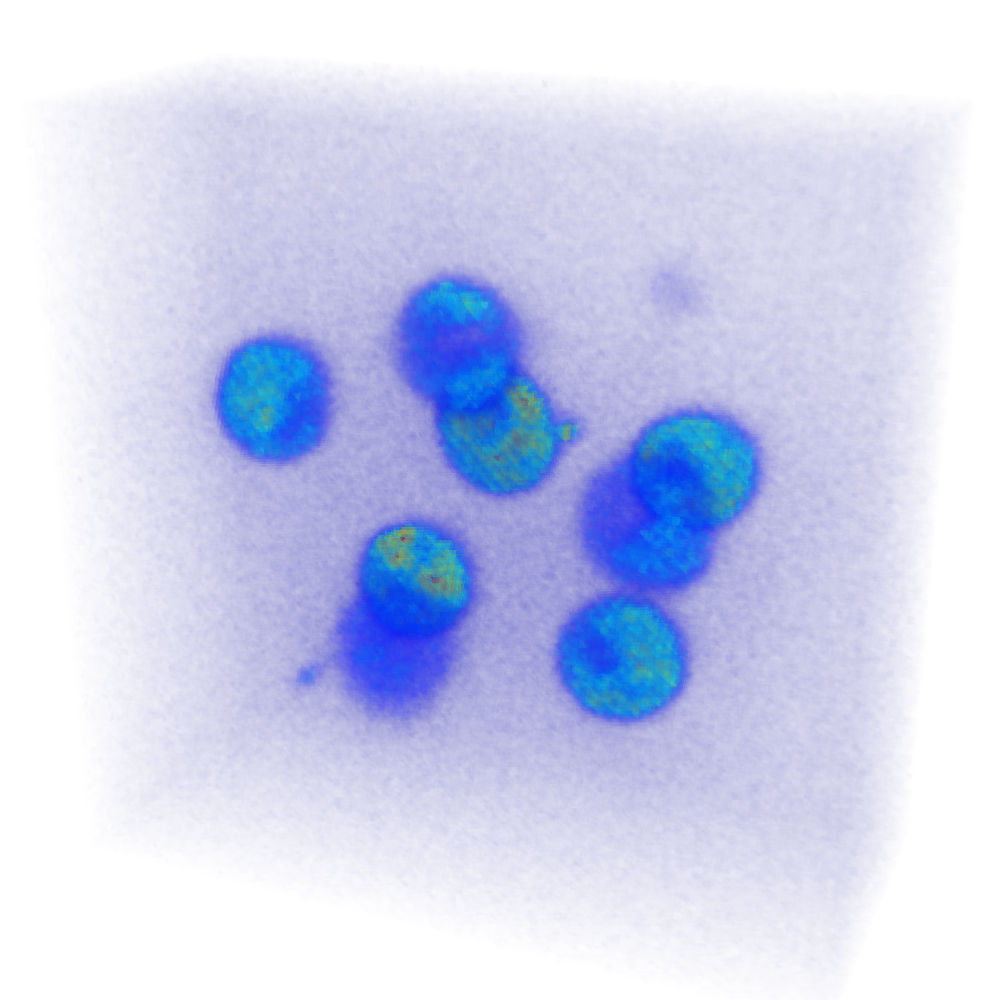

int32
uint8


In [151]:
pl = pv.Plotter(notebook = True, window_size = (1000,1000),polygon_smoothing = True )
embryo_index = 1
embryo_time_index = 6
index = int((embryo_index-1) * 11 + embryo_time_index)
print(index)
image, truth = test_data[index]

image = io.imread(test_data_paths[index])
filename = test_data_paths[index].split('/')[-1]
ground_truth = io.imread(ground_truth_test + filename)

data = pv.wrap(image)
pl.add_volume(data, cmap = "jet",
              opacity= [0,0.15,0.4,0.6,0.8,1,1,1],
              shade = False)
pl.camera.position= (250.0, 150.0,150.0)
pl.remove_scalar_bar()
pl.show(jupyter_backend= 'Static')
np.unique(ground_truth)
print(segmented_QCANet.dtype)
print(ground_truth.dtype)

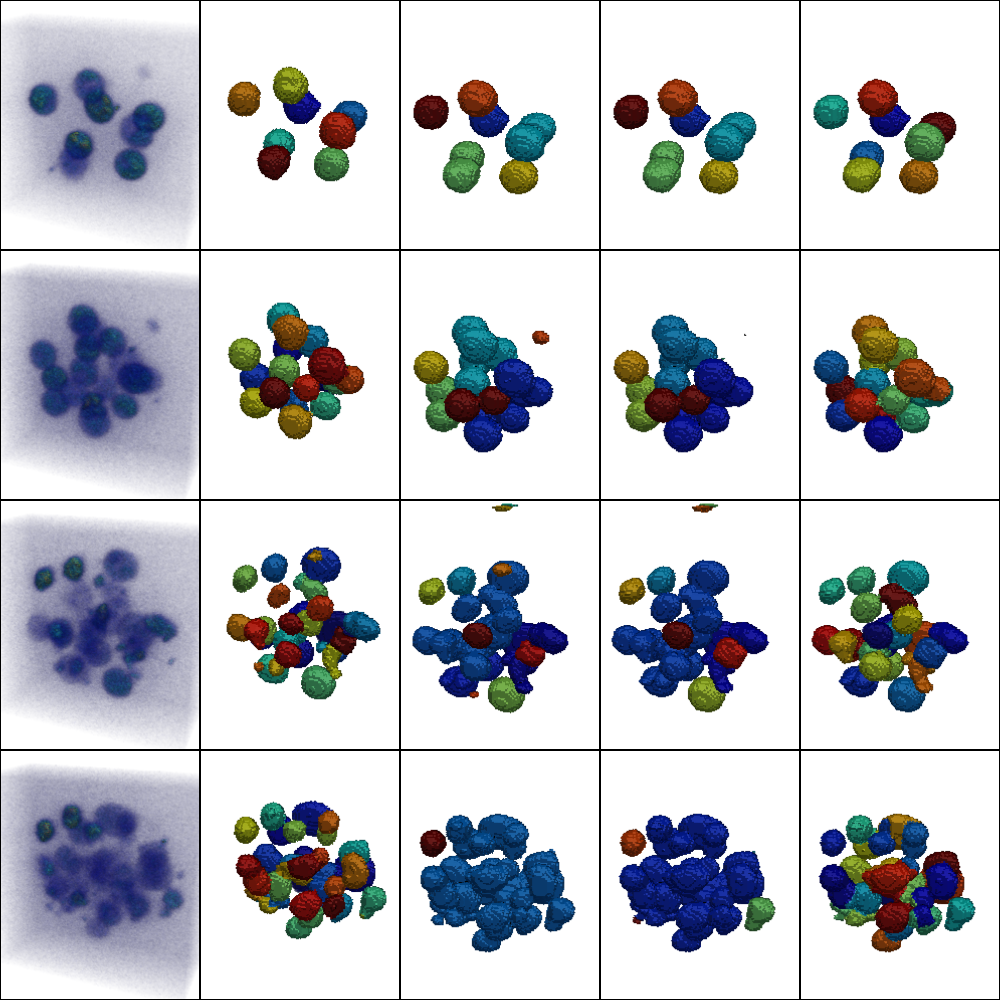

In [152]:
embryo_index = 1
pl = pv.Plotter(notebook = True, shape = (4,5), window_size = (1000,1000),polygon_smoothing = True )
for i,embryo_time_index in enumerate([6,8,9,10]):
    prediction_NSN_128 = torch.Tensor.numpy(prediction_set(test_data, net_NSN, device, embryo_index, embryo_time_index))
    prediction_unet_128 = torch.Tensor.numpy(prediction_set(test_data, net_unet, device, embryo_index,embryo_time_index))
    prediction_NDN_128 = torch.Tensor.numpy(prediction_set(test_data, net_NDN, device, embryo_index, embryo_time_index))
    
    prediction_unet = (tr.resize(prediction_unet_128, output_shape = [51,128,128],anti_aliasing=False)>0)*1
    prediction_NDN = (tr.resize(prediction_NDN_128, output_shape = [51,128,128],anti_aliasing=False)>0)*1
    prediction_NSN = (tr.resize(prediction_NSN_128, output_shape = [51,128,128],anti_aliasing=False)>0)*1
    
    segmented_NSN, segmented_QCANet, segmented_unet = Watershed_function(prediction_NSN, prediction_NDN, prediction_unet)
    
    index = int((embryo_index-1) * 11 + embryo_time_index)
    image = io.imread(test_data_paths[index])
    
    data = pv.wrap(image)
    pl.subplot(i,0)
    pl.add_volume(data, cmap = "jet",
              opacity= [0,0.4,0.9,1],
                shade = True)
    pl.camera.position= (250.0, 150.0,150.0)
    pl.remove_scalar_bar()
    
    filename = test_data_paths[index].split('/')[-1]
    ground_truth = io.imread(ground_truth_test + filename)
    
    data = pv.wrap(np.int32(ground_truth))
    pl.subplot(i,1)
    pl.add_volume(data, cmap = "jet",
              opacity= [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                shade = True)
    pl.camera.position= (250.0, 150.0,150.0)
    pl.remove_scalar_bar()
    
    data = pv.wrap(segmented_unet)
    pl.subplot(i,2)
    pl.add_volume(data, cmap = "jet",
                  opacity= [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                    shade = True)
    pl.camera.position= (250.0, 150.0,150.0)
    pl.remove_scalar_bar()
    
    data = pv.wrap(segmented_NSN)
    pl.subplot(i,3)
    pl.add_volume(data, cmap = "jet",
                  opacity= [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                    shade = True)
    pl.camera.position= (250.0, 150.0,150.0)
    pl.remove_scalar_bar()
    
    data = pv.wrap(segmented_QCANet)
    pl.subplot(i,4)
    pl.add_volume(data, cmap = "jet",
                  opacity= [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
                    shade = True)
    pl.camera.position= (250.0, 150.0,150.0)
    pl.remove_scalar_bar()
    
pl.show(jupyter_backend= 'Static')


In [153]:
pl.screenshot('Test1.png')  
pl.screenshot('Test2',scale=4)
pl.save_graphic("pdf_test.pdf",raster=False)

In [26]:
np.unique(data)

array([ImageData (0x1cdceee41c0)
         N Cells:      627150
         N Points:     651168
         X Bounds:     0.000e+00, 5.000e+01
         Y Bounds:     0.000e+00, 1.130e+02
         Z Bounds:     0.000e+00, 1.110e+02
         Dimensions:   51, 114, 112
         Spacing:      1.000e+00, 1.000e+00, 1.000e+00
         N Arrays:     1                              ], dtype=object)

In [134]:
viewing3D_funtion(prediction_NSN, prediction_NDN, prediction_unet, segmented_NSN, segmented_QCANet,segmented_unet)